In [1]:
from keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, UpSampling2D, ZeroPadding2D, Dropout, Dense, Reshape, Lambda, Flatten 
from keras import optimizers
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np
import glob
import scipy
from keras.regularizers import l2
import tensorflow as tf

/home/aminov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from PIL import Image
import io
from keras.preprocessing import image
from sklearn.utils import shuffle

import sys
import time

In [3]:
W=128

In [4]:
pics0 = glob.glob("../data/*")
pics1 = glob.glob("../data2/*")
pics2 = glob.glob("../data3/*.jpg")
 
# pics0 = shuffle(pics0)
# pics1 = shuffle(pics1)
# pics = pics2+pics1+pics0
pics3 = shuffle(pics3)
pics = pics3

In [5]:
len(pics)

2031

In [6]:
per20 = int(0.1*len(pics))
per20

203

In [7]:
def gen_train_image():
    while True:pics3 = glob.glob("../images/images/*.jpg")

        for url in pics[:-per20]:
            img = Image.open(url)#.convert('L')
            img = image.img_to_array(img.resize((W,W))) / 255.
            noise_factor = 0.1
            img_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0)
            yield np.reshape(img_noisy,(1,W,W,3)), np.reshape(img,(1,W,W,3))

def gen_test_image():
    while True:
        for url in pics[-per20:]:
            img = Image.open(url)#.convert('L')
            img = image.img_to_array(img.resize((W,W))) / 255.
            noise_factor = 0.1
            img_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0)
            yield np.reshape(img_noisy,(1,W,W,3)), np.reshape(img,(1,W,W,3))

In [9]:
import keras
from keras import backend as K
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, GlobalMaxPooling1D, UpSampling1D , UpSampling2D

def Conv(input_img, filters, kernels_size = (3,3), pool_size = (2,2)):
    x = Conv2D(filters, kernels_size, activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size, padding='same')(x)
    return x

def DeConv(input_img, filters, kernels_size = (3,3), pool_size = (2,2)):
    x = Conv2D(filters, kernels_size, activation='relu', padding='same')(input_img)
    x = UpSampling2D(pool_size)(x)
    return x

def train_model():
    input_img = Input(shape=(W, W, 3))
    x = Conv(input_img, 32)
    x = Conv(x, 32)
    x = Conv(x, 64)
    
    flat = Flatten()(x)
    x = Reshape((16, 16, 64))(flat)
    
    x = DeConv(x, 64)
    x = DeConv(x, 32)
    x = DeConv(x, 32)
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
    
    encoder = Model(input_img, flat, name="encoder")
    autoencoder = Model(input_img, decoded)
    
    adam = optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    autoencoder.compile(optimizer=adam, loss='mse')
    
    print(autoencoder.summary())
    return autoencoder, encoder



In [10]:
autoencoder, encoder = train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

Epoch 1/7
1828/1828 [==============================] - 27s 15ms/step - loss: 0.0224 - val_loss: 0.0146
Epoch 2/7
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 3/7
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 4/7
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 5/7
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 6/7
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 7/7
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0089 - val_loss: 0.0095


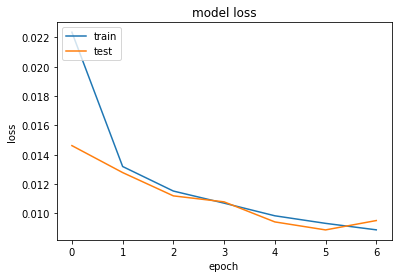

In [292]:
history  = autoencoder.fit_generator(gen_train_image(),
                epochs=7,
                steps_per_epoch=len(pics)-per20,
                validation_data=gen_test_image(),
                validation_steps=600)


autoencoder.save('res/autoencoder.h5')
encoder.save('res/encoder.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [293]:
adam = optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
autoencoder.compile(optimizer=adam, loss='mse')

history  = autoencoder.fit_generator(gen_train_image(),
                epochs=1000,
                steps_per_epoch=len(pics)-per20,
                validation_data=gen_test_image(),
                validation_steps=600)


autoencoder.save('res/autoencoder.h5')
encoder.save('res/encoder.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/1000
1828/1828 [==============================] - 26s 14ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 2/1000
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 3/1000
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 4/1000
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 5/1000
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 6/1000
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 7/1000
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 8/1000
1828/1828 [==============================] - 23s 13ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 9/1000
1828/1828 [==============================] - 23s 12ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 10/1000
1828/1828 [=====================

KeyboardInterrupt: 

In [17]:
from keras.models import load_model
# autoencoder = load_model('1_autoencoder.h5')
# encoder = load_model('1_encoder.h5')
import h5py
f = h5py.File('res/autoencoder.h5', 'r')
print(f.attrs.get('keras_version'))

b'2.1.5'


In [294]:
learned_codes = encoder.predict_generator(gen_train_image(),len(pics)-per20)

In [295]:
ae_res = autoencoder.predict_generator(gen_train_image(),len(pics)-15)

In [296]:
def retrieve_closest_images(test_element, test_label, n_samples=10):
    test_code = encoder.predict(test_element)
    distances = []
    hashs = []
    dict_={}
    for i in range(len(learned_codes)):
       
#         distance = np.linalg.norm(learned_codes[i] - test_code)
        distance = scipy.spatial.distance.cosine(learned_codes[i], test_code[0])
#         distance = scipy.spatial.distance.euclidean(learned_codes[i], test_code[0])
#         distance = scipy.spatial.distance.hamming(learned_codes[i], test_code[0])
#         distance = np.mean((learned_codes[i]- test_code[0])**2)
        distances.append(distance)
        hashs.append(learned_codes[i])
        if distance in dict_:
            distance+=(0.0000001/i)
        dict_.update({distance:i})
    
    print('lengths= ',len(dict_),len(learned_codes))
    
    return dict_

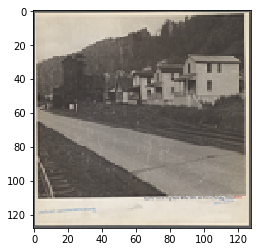

In [300]:
im = Image.open('../images/images/5251492.jpg')
im = im.resize((W,W))
im = image.img_to_array(im)
im = im / 255.
plt.imshow(im)
plt.show()

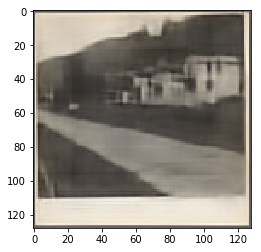

In [301]:
p_im = autoencoder.predict(np.reshape(im,(1,W,W,3)))

plt.imshow(p_im[0])
plt.show()

lengths=  1828 1828


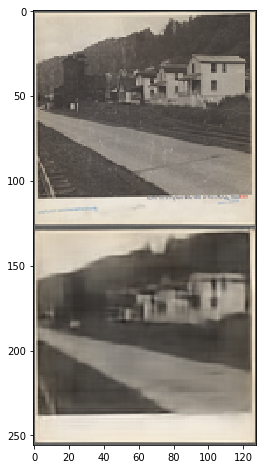

1152 0.004243791103363037


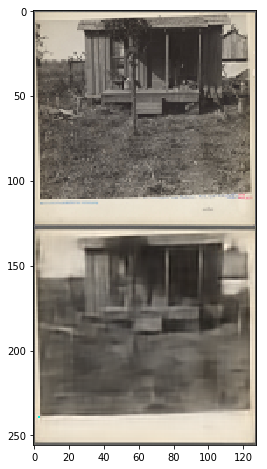

1803 0.2207791805267334


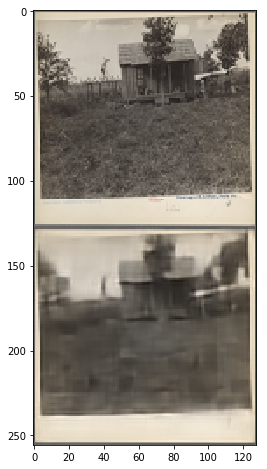

1079 0.2295072078704834


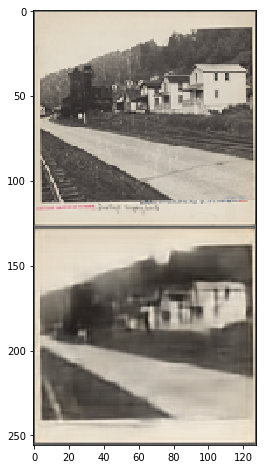

1554 0.23497188091278076


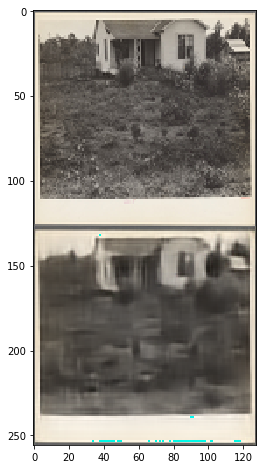

370 0.2402588129043579


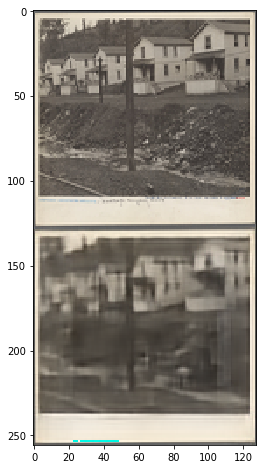

684 0.24510711431503296


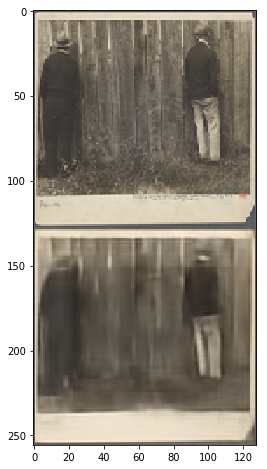

799 0.2457546591758728


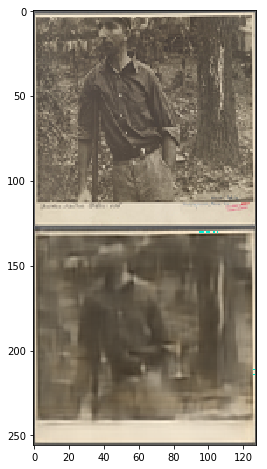

1647 0.2528179883956909


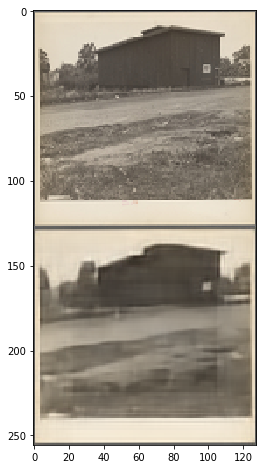

703 0.2572289705276489


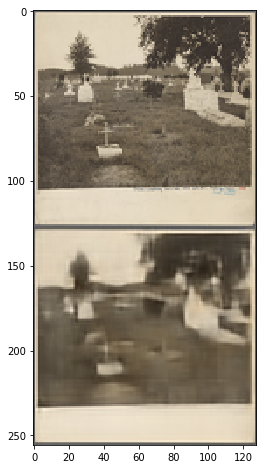

1480 0.2573789954185486


In [302]:
dict_ = retrieve_closest_images(np.expand_dims(im, axis=0), 0, 70)
for i in sorted(dict_)[:10]:
    plt.figure(figsize=(4,8))
    imr = Image.open(pics[dict_[i]])
    imr = imr.resize((W,W))
    imr = image.img_to_array(imr)
    imr = imr / 255.

    
    p_im = autoencoder.predict(np.reshape(imr,(1,W,W,3)))
    plt.imshow(np.concatenate((imr,p_im[0]), axis=0), aspect='auto')
    plt.show()
    print(dict_[i],i)